# Using Random Forrest classification to identify succesful marketing campaigns

__SID: 440243151__
__Unikey: tilc3736__

As part of  Assigment 2A, tree-based classification algorithms were identified as a frontrunner for appropriate modelling of bank marketting data.

This report will propose a random forrest model and assess its efficacy. The model will be compared against those produced by team-members.



In [1]:
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing
from time import strptime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [2]:
df = pd.read_csv('bank-additional-full.csv')
df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Test-Train Split
__same approach and random seed used by all team members, to control against random__

We also have to transform training data into an array, with all numeric data.

In [3]:
from sklearn.model_selection import train_test_split

df.loc[(df.y == 'yes'),'y'] = 1
df.loc[(df.y == 'no'),'y']= 0
df['y'] = df['y'].astype(int)

bank_data = df.iloc[:, :-1]
bank_y = df['y'].astype(int)


X_train, X_test, Y_train, Y_test = train_test_split(bank_data, bank_y, test_size=0.2,
                                                    random_state=7,stratify = bank_y)

X_test_copy = X_test
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

feature_list = list(X_train.columns)

X_train = np.array(X_train)
X_test = np.array(X_test)


### Baseline Model

Firstly a primitive model is fit to get a rough idea of what baseline accuracy is.
This provides a yardstick for what we should be aiming to outperform.

In [4]:
rf_b  = RandomForestRegressor(n_estimators = 1000, random_state = 42)

pre_temp = time.time()
rf_b.fit(X_train,Y_train)
post_temp = time.time()

print("Time elapsed (real): ", post_temp-pre_temp)

Time elapsed (real):  159.1158311367035


In [5]:
from sklearn import metrics

from sklearn.metrics import classification_report

def evaluate(rf, X_test, Y_test):
    predictions = rf.predict(X_test)
    auc = metrics.roc_auc_score(Y_test,predictions)
    print('Model Performance:')
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Area under ROC = {:2f}%.'.format(auc*100))
    print('Gini Coefficient/ Somers D = {:2f}%.'.format((2*auc-1)*100))

    print('Classification Report (using 50% probability cut-off):')
    predictions_discrete = np.where(predictions > 0.5,1,0)
    print(classification_report(Y_test, predictions_discrete))
    return accuracy

accuracy = evaluate(rf_b,X_test,Y_test)


Model Performance:
Area under ROC = 94.571995%.
Gini Coefficient/ Somers D = 89.143990%.
Classification Report (using 50% probability cut-off):
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.64      0.53      0.58       928

    accuracy                           0.91      8238
   macro avg       0.79      0.75      0.77      8238
weighted avg       0.91      0.91      0.91      8238



NameError: name 'accuracy' is not defined

### Hyper-Parameter Tuning

There are 16 parameters to tune in sklearn random forest.
Normally brute force experimentation could be used to iterate through each variable, however with 16 variables (many requiring continuous imput) this becomes  (well over 1m iterations even at sensible quantums).

Not all hyperparameters are highly critical/influential. Documentation and literature suggests number of trees in forest (n_estimators) and number of features (max_features) are of particular importance.

A full list of hypterparameters is listed below:

In [ ]:
print('Parameters in algorithm:\n')
pprint(rf.get_params())

Parameters in algorithm:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 2000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}


For the purposes of tuning hyperparameters, a 25% subsample of train dataset is used - and gini is calculated on 75% ramaining data.

Currently a model takes around 2 minutes to train, to iterate over multiple iterations of 16 parameters would take too long.›

The final proposed will be recreated using full training dataset, prior to validation on test dataset.

Note that for similar reasons, a grid search isnt performed - instead hyperparameters are optimised one by one.

In [ ]:

X_train_small, X_test_small, Y_train_small, Y_test_small = train_test_split(X_train, Y_train, test_size=0.75,
                                                    random_state=7,stratify = Y_train)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Trees in Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 4)]
# features to consider at every split
max_features = ['auto', 'sqrt']

max_depth.append(None)

# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': ['1', '5', '15', '30', 'None', None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 733, 1366, 2000]}


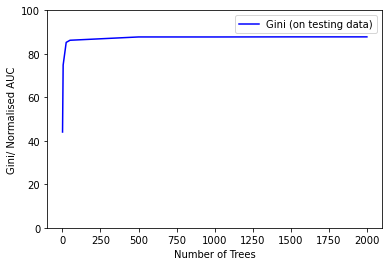

In [ ]:

import matplotlib.pyplot as plt
ginis = []
n_trees = []

for i in [1,5,25,50,500,1000,1500,2000]:
    rf  = RandomForestRegressor(n_estimators = i, random_state = 7)
    rf.fit(X_train_small,Y_train_small)

    predictions = rf.predict(X_test_small)
    gini = (2*metrics.roc_auc_score(Y_test_small,predictions)-1)*100

    ginis.append(gini)
    n_trees.append(i)



plt.plot(n_trees, ginis, c='b', label='Gini (on testing data)')
plt.ylim(0,100)
plt.ylabel('Gini/ Normalised AUC')
plt.xlabel('Number of Trees')
plt.legend()
plt.show()

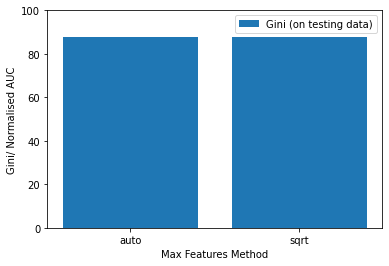

In [ ]:
ginis = []
max_features = []

for i in ['auto','sqrt']:
    rf  = RandomForestRegressor(n_estimators = 2000,max_features=i, random_state = 7)
    rf.fit(X_train_small,Y_train_small)

    predictions = rf.predict(X_test_small)
    gini = (2*metrics.roc_auc_score(Y_test_small,predictions)-1)*100

    ginis.append(gini)
    max_features.append(i)

plt.bar(max_features, ginis, label='Gini (on testing data)')
plt.ylim(0,100)
plt.ylabel('Gini/ Normalised AUC')
plt.xlabel('Max Features Method')
plt.legend()
plt.show()

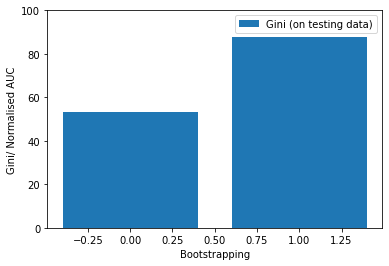

In [ ]:
ginis = []
bootstrap = []

for i in [True,False]:
    rf  = RandomForestRegressor(n_estimators = 2000,max_features='auto', random_state = 7,bootstrap = i)
    rf.fit(X_train_small,Y_train_small)

    predictions = rf.predict(X_test_small)
    gini = (2*metrics.roc_auc_score(Y_test_small,predictions)-1)*100

    ginis.append(gini)
    bootstrap.append(i)

plt.bar(bootstrap, ginis, label='Gini (on testing data)')
plt.ylim(0,100)
plt.ylabel('Gini/ Normalised AUC')
plt.xlabel('Bootstrapping')
plt.legend()
plt.show()

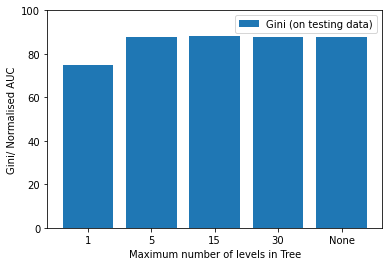

In [ ]:

import matplotlib.pyplot as plt
ginis = []
max_depth = []

for i in [1,5,15, 30, None]:
    rf  = RandomForestRegressor(n_estimators = 2000,max_features='auto', random_state = 7,bootstrap = True,max_depth=i)
    rf.fit(X_train_small,Y_train_small)

    predictions = rf.predict(X_test_small)
    gini = (2*metrics.roc_auc_score(Y_test_small,predictions)-1)*100

    ginis.append(gini)
    max_depth.append(str(i))




plt.bar(max_depth, ginis, label='Gini (on testing data)')
plt.ylim(0,100)
plt.ylabel('Gini/ Normalised AUC')
plt.xlabel('Maximum number of levels in Tree')
plt.legend()
plt.show()

### Evaluation of model with tuned hyper-parameters

based on our experimentation, 1-by-1 approach, the following parameters were selected:

- number of trees: 2000. Discrimination has reached an asymptote, it may continue to improve at higher numbers, however the training time would be too expensive for these incrimental improvements. If run time is a concern, a lower number of trees can be selected with unnoticable
- max features: auto
- bootstrapping: true
- maximum depth of trees: 5
    
Accordingly, a final model is built on the full test dataset and selected parameters - and evaluated compelely on training dataset.

In [ ]:
rf_final  = RandomForestRegressor(n_estimators = 2000,max_features='auto', random_state = 7,bootstrap = True,max_depth=5)

rf_final.fit(X_train_small,Y_train_small)

predictions = rf_final.predict(X_test)


accuracy = evaluate(rf_final,X_test,Y_test)


Model Performance:
Area under ROC = 94.227403%.
Gini Coefficient/ Somers D = 88.454806%.
Classification Report (using 50% probability cut-off):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7310
           1       0.67      0.51      0.58       928

    accuracy                           0.92      8238
   macro avg       0.81      0.74      0.77      8238
weighted avg       0.91      0.92      0.91      8238



In summary tuning the hyperparameters has offered an underwhelming benefit in some areas - with offsetting tradeoffs in others.

- Accuracy has increased 1% to 92%.
- AUROC (i.e. discrimination) has decreased 1%, from 95% to 94%
- precision has improved 3% for succesfull sales
- recall has deteriorated 2%
- f1-score is unchanged


There are, of course, further permutations that could be tested - however it is clear at this point that it isnt going to provide a silver bullet.

On the bright side, the model performs relatively well both before and after the tune. Discrimination - perhaps the best measure of binary classification suitability on unbalanced data, remains high - with a AUC of 94% (normalised equivalent of 88%). Accurarcy is also relatively high at the somewhat arbitrary, but intuitive cutoff of 50%.



<function matplotlib.pyplot.show(close=None, block=None)>

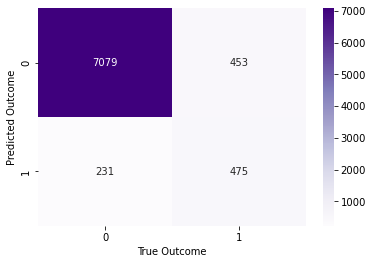

In [ ]:
from sklearn.metrics import confusion_matrix


predictions = rf_final.predict(X_test)
predictions_discrete = np.where(predictions > 0.5,1,0)

test = confusion_matrix(predictions_discrete,Y_test)

rnd = np.round(test).astype(int)

ax=sns.heatmap(test, annot=True,fmt='.0f',cmap="Purples")
ax.set(xlabel='True Outcome',ylabel='Predicted Outcome')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

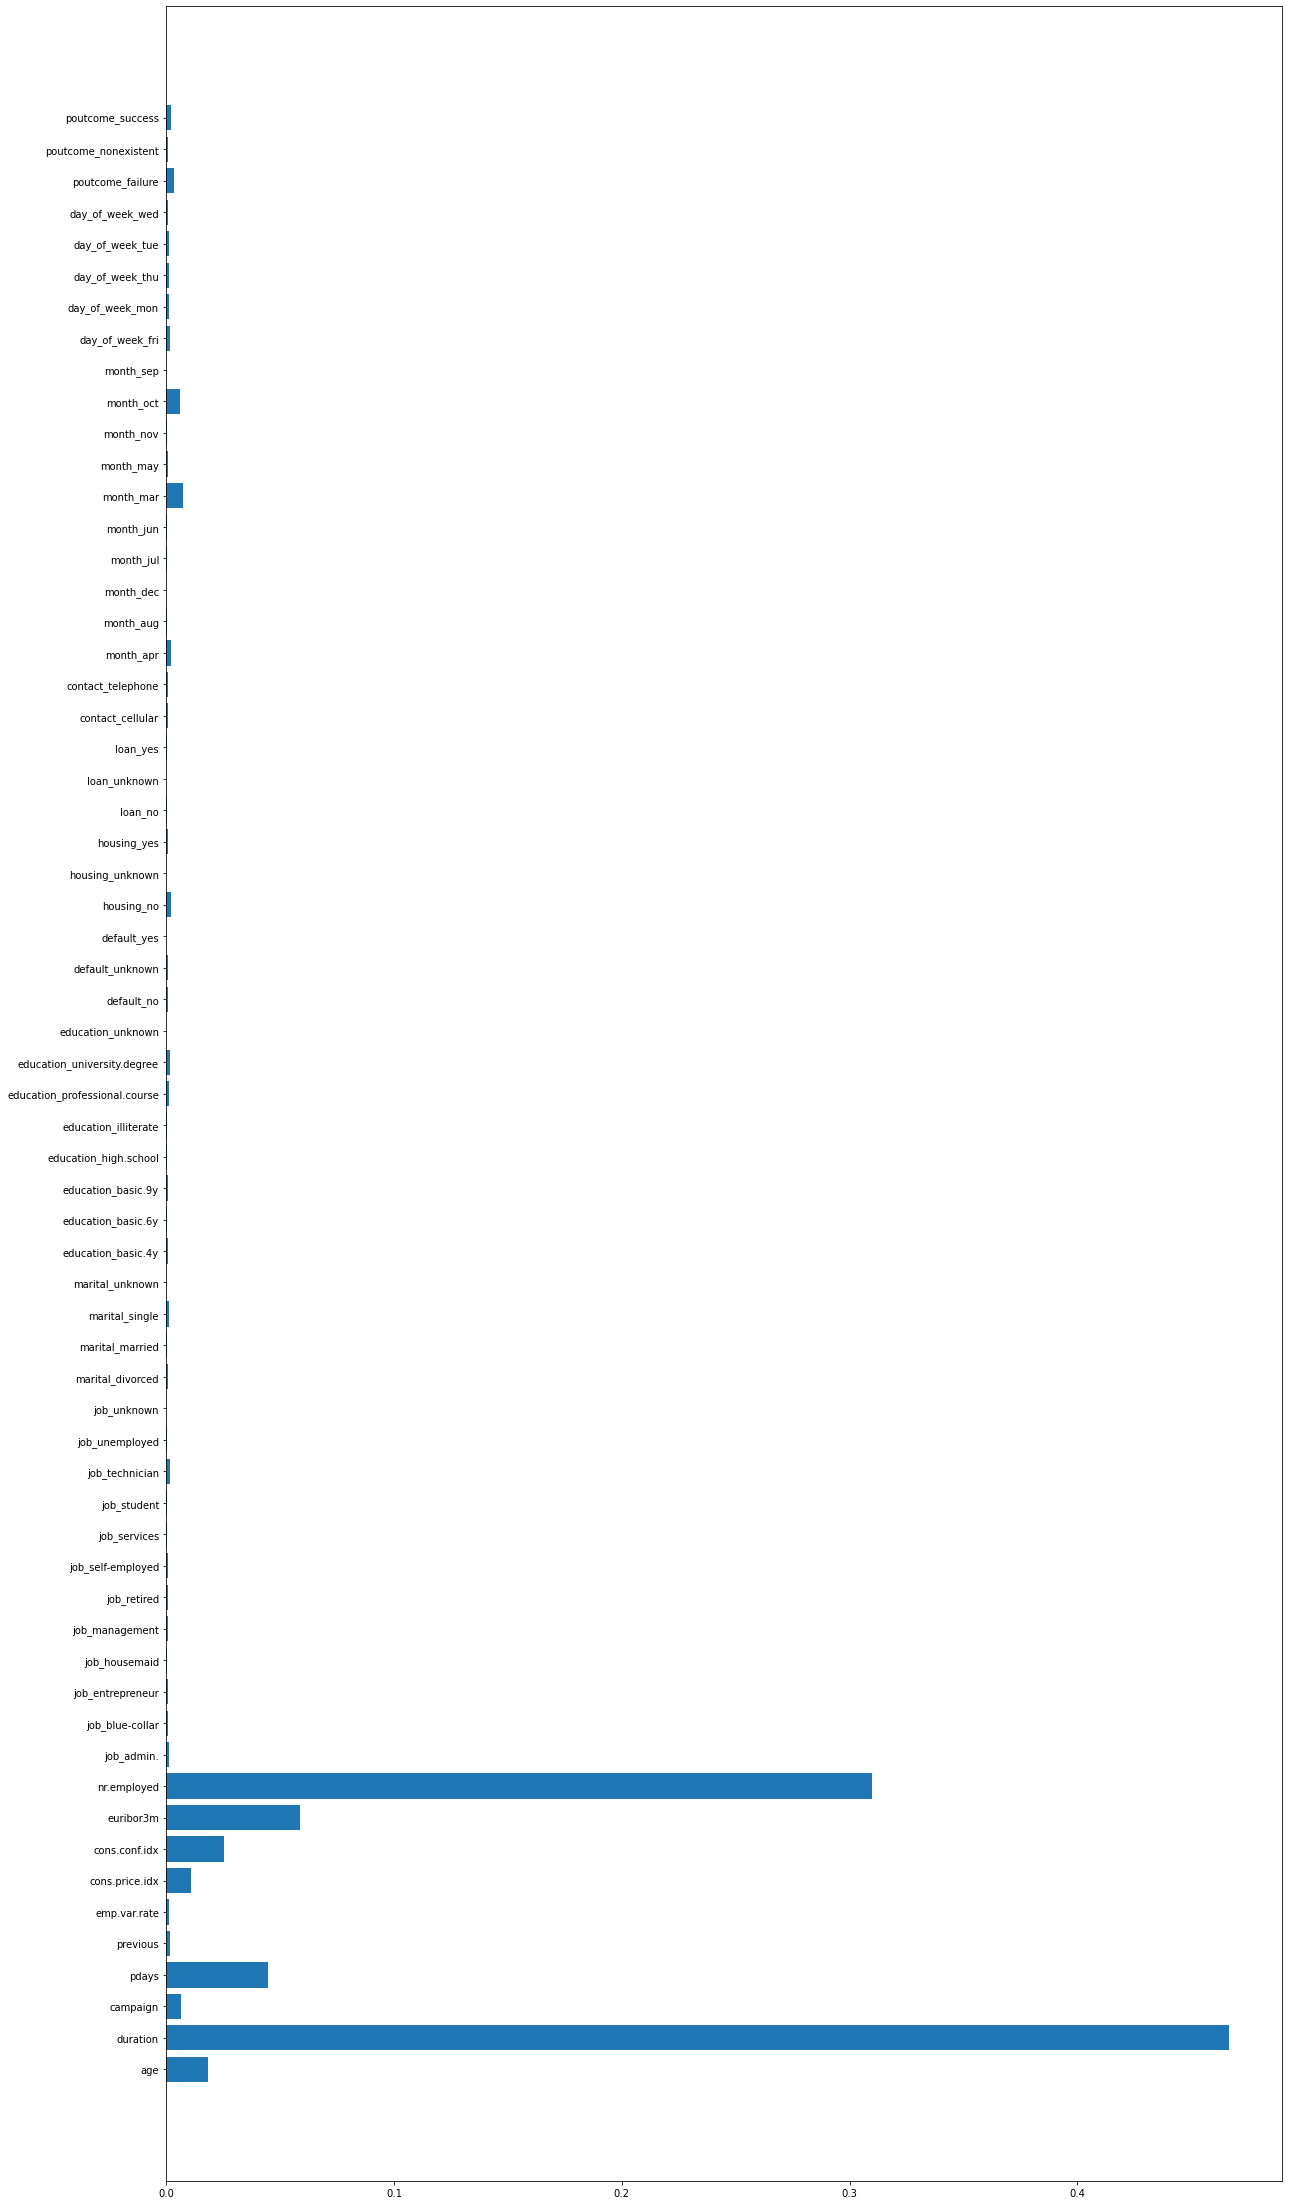

In [ ]:
plt.barh(feature_list,rf_final.feature_importances_)
plt.rcParams['figure.figsize'] = [10,40]
plt.show

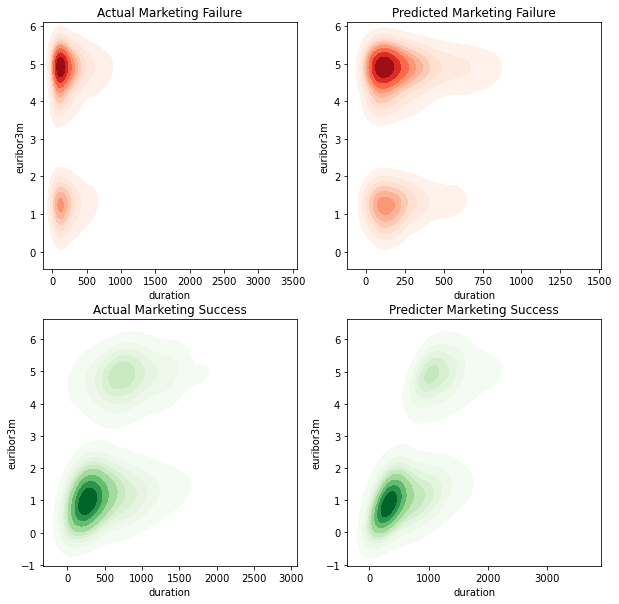

In [ ]:

plot_no_p = X_test_copy.copy()
plot_no_p = plot_no_p[predictions_discrete==0]

plot_yes_p = X_test_copy.copy()
plot_yes_p = plot_yes_p[predictions_discrete==1]



plot_no = X_test_copy.copy()
plot_no = plot_no[Y_test==0]

plot_yes = X_test_copy.copy()
plot_yes = plot_yes[Y_test==1]

fig, axes = plt.subplots(2,2)

axes[0,0].set_title("Actual Marketing Failure")
sns.kdeplot(ax=axes[0,0],x=plot_no['duration'],y=plot_no['euribor3m'], cmap='Reds',shade=True)
axes[1,0].set_title("Actual Marketing Success")
sns.kdeplot(ax=axes[1,0],x=plot_yes['duration'],y=plot_yes['euribor3m'], cmap='Greens',shade=True)

axes[0,1].set_title("Predicted Marketing Failure")
sns.kdeplot(ax=axes[0,1],x=plot_no_p['duration'],y=plot_no_p['euribor3m'], cmap='Reds',shade=True)
axes[1,1].set_title("Predicter Marketing Success")
sns.kdeplot(ax=axes[1,1],x=plot_yes_p['duration'],y=plot_yes_p['euribor3m'], cmap='Greens',shade=True)

plt.rcParams['figure.figsize'] = [10,10]
plt.show()